# ⛳ 나는 스케치를 너는 채색을..... ⛳

## 들어가며..

2014년 GAN(Generative Adversarial Networks)이 세상에 나타난 이후, Computer Vision 및 다양한 분야에서 많은 관심을 받아 활발하게 응용되면서 빠르게 발전해 왔다.

오늘은 이미지 생성 모델로 사용되는 일반적인 GAN에 조건을 부여하여 내가 원하는 유형의 이미지를 생성해 낼 수 있도록 하는 방법에 대해 알아보자.

오늘 진행할 내용에는 Tensorflow로 신경망을 구현하는 과정을 보고 이해하는 부분이 많다.

### 학습 목표
___

- 조건을 부여하여 생성 모델을 다루는 방법에 대해 이해
- cGAN 및 Pix2Pix의 구조와 학습 방법을 이해하고 잘 활용
- CNN 기반의 모델을 구현하는데 자신감

### 학습 전제
___

- Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법에 대해 대략적인 이해
- 신경망의 학습 방법에 대한 전반적인 절차
- CNN, GAN에 대한 기본적인 개념
- Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해
- (중요) Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해 보려는 의지

### 목차
___

1. 조건 없는 생성 모델(Unconditional Generative Model), GAN

2. 조건 있는 생성 모델(Conditional Generative Model), cGAN

## 1. 조건 없는 생성모델(Unconditional Generative Model), GAN

GAN을 이용해 MNIST, CIFAR-10 등의 데이터셋을 학습하고 생성하고 성공적으로 학습되었다면, 아래와 같이 학습에 사용한 실제 손글씨 이미지와 매우 유사한 손글씨 이미지를 생성이 가능하다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/mnist_results.max-800x600.png)

여기서 한 가지 생각해보자.

예를 들어, "9"이라는 이미지를 만들고자 MNIST 데이터셋을 이용해 GAN을 열심히 학습시켰다.

학습이 완료된 모델을 이용해 "9"이라 쓰여있는 이미지를 얻기 위해 어떤 방법을 이용해야 할까?

여기서 할 수 있는 방법으로는 그저 다양한 노이즈를 계속 입력으로 넣어보고 "9"이라는 숫자 이미지가 생성되길 기다릴 뿐이다.

운이 좋다면 한 번에 만들 수 있겠지만 운이 없다면 100개가 넘는 이미지를 생성해도 9이 나오지 않을 수 있다.

또한 혹시라도 "9" 이미지를 수만 개 만들어야 한다면, 새로운 노이즈 입력을 몇 번이나 넣어야 할지 엄청난 노가다가 필요할 것이다.

잘 학습된 GAN을 이용해 실제 이미지를 생성할 때 조금 답답한 점이 하나 있다면, 바로 내가 원하는 종류의 이미지를 바로 생성해 내지 못한다는 것이다.

다시 말해서 일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들었다.

우리가 원하는 이미지를 바로바로 생성해 내기 위해서는 어떤 방법을 이용해야 할까?

GAN이라는 생성 모델에 내가 원하는 이미지를 만들기 위한 특정 조건을 줄 수는 없을까?

우리는 마냥 "9"이라 쓰인 이미지가 생성되길 기다릴 순 없다.

## 2. 조건 있는 생성모델(Conditional Generative Model), cGAN

**Conditional Generative Adversarial Nets (cGAN)** 은 내가 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법이다.

만약 GAN을 잘 이해하고 있다면 이 방법(cGAN)은 전혀 어렵지 않을 것이다.

### GAN의 목적 함수
___

먼저 GAN에 대해 간단히 복습해 보자. GAN 구조는 Generator 및 Discriminator라 불리는 두 신경망이 minimax game을 통해 서로 경쟁하며 발전한다.

이를 아래와 같은 식으로 나타낼 수 있으며 Generator는 이 식을 최소화하려, Discriminator는 이 식을 최대화하려 학습할 것이다.

$min_Gmax_DV(D,G)=$

$E_{x∼p_{data}(x)}[logD(x)+E_{z∼p_x(z)}[log(1-D(G(z)))]$
​


위 식에서 $z$는 임의 노이즈를, $D$와 $G$는 각각 Discriminator 및 Generator를 의미한다.

1. 먼저 $D$의 입장에서 식을 보자.

실제 이미지를 1, 가짜 이미지를 0으로 두었을 때, $D$는 이 식을 최대화해야 하며, 우변의 + 를 기준으로 양쪽의 항 $(logD(x))$ 및 $log(1-D(G(z)))$ 이 모두 최대가 되게 해야 한다.

이를 위해서 두 개의 $log$가 1이 되게 해야한다.

$D(x)$는 1이 되도록, $D(G(z))$는 0이 되도록 해야 한다.   
다시 말하면, 진짜 데이터 $(x)$를 진짜로, 가짜 데이터 $(G(z))$를 가짜로 정확히 예측하도록 학습한다는 뜻이다.

2. $G$의 입장에서 식을 보자.

$D$와 반대로 $G$는 위 식을 최소화 해야하고 위 수식에서는 마지막 항 $log(1-D(G(z)))$만을 최소화하면 된다.(우변의 첫 번째 항은 $G$와 관련이 없다.)

이를 최소화한다는 것은 $log$ 내부가 0이 되도록 해야 함을 뜻하며, $D(G(z))$가 1이 되도록 한다는 말이다.

즉, $G$는 $z$를 입력받아 생성한 데이터 $G(z)$를 $D$가 진짜 데이터라고 예측할 만큼 진짜 같은 데이터를 만들도록 학습한다는 뜻이다.

### cGAN의 목적 함수
___

GAN과 비교하며 알아볼 cGAN의 목적함수는 아래와 같다.

$min_Gmax_DV(D,G)=$

$E_{x∼p_{data}(x)}[logD(x|y)]+E_{x∼p_x(z)}[log(1-D(G(z|y)))]$

### Question 1.

> cGAN의 목적함수는 GAN의 목적함수와 비교하여 어떤 부분이 바뀌었나?

▶ $D(x)$와 $G(z)$가 각각 $D(x∣y)$, $G(z∣y)$로 바뀌었다.

$G$와 $D$의 입력에 특정 조건을 나타내는 정보인 $y$를 같이 입력한다는 것이다.

이외에는 GAN의 목적함수와 동일하므로 각각 $y$를 추가로 입력받아 $G$의 입장에서 식을 최소화하고, $D$의 입장에서 식을 최대화하도록 학습한다.

여기서 함께 입력하는 $y$는 어떠한 정보여도 상관없으며, MNIST 데이터셋을 학습시키는 경우 $y$는 0 ~ 9 까지의 label 정보가 된다.

Generator 가 어떠한 노이즈 $z$를 어떠한 이미지로 만들어야할지에 대한 방향을 제어할 수 있게 된다.

조금 다르게 표현하면 $y$가 임의의 노이즈 입력인 $z$의 가이드라고 할 수 있다.

### 그림으로 이해하기
___

GAN과 cGAN의 Feed forward 과정을 그림으로 비교해보자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/gan_img.max-800x600.png)

GAN의 학습과정은 위 그림과 같다.

- **Generator **  
노이즈 $z$(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 $G(z)$ (빨간색)를 생성한다.

- **Discriminator**   
실제 데이터 $x$와 Generator가 생성한 가짜 데이터 $G(z)$를 각각 입력받아 $D(x)$ 및 $D(G(z))$(보라색)를 계산하여 진짜와 가짜를 식별한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/cgan_img.max-800x600.png)

이전 목적함수에서 확인했듯이, cGAN에서 바뀐 부분은 $y$라는 정보가 함께 입력된다.

- **Generator** 노이즈 $z$(파란색)와 추가 정보 $y$(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 $G(z∣y)$를 생성한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 $y$는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣는다.

- **Discriminator** 실제 데이터 $x$와 Generator가 생성한 가짜 데이터 $G(z∣y)$를 각각 입력받으며, 마찬가지로 $y$정보가 각각 함께 입력되어 진짜와 가짜를 식별한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 $x$와 $y$는 알맞은 한 쌍("9"이라 쓰인 이미지의 경우 레이블도 9)을 이뤄야 하며, 마찬가지로 Generator에 입력된 $y$와 Discriminator에 입력되는 $y$는 동일한 레이블을 나타내야 한다.

# 다음 $STEP$에서는 Generator을 구성해보자.

# ⛳ 나는 스케치를 너는 채색을..... ⛳

## 목차
___

3. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

4. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

5. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

## 3. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기

이제부터는 앞에서 계속 비교해온 GAN과 cGAN을 각각 간단하게 구현하고 실험해 보자.

간단한 실험을 위해 MNIST 데이터셋을 이용할 것이다.

- [TF2-GAN](https://github.com/thisisiron/TF2-GAN)

### 데이터 준비하기
___

tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋을 불러와 확인해보자.

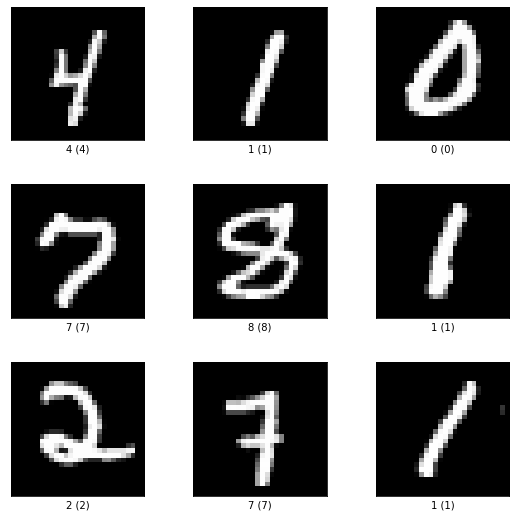

In [40]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었을 것이다. 이어서 아래 코드를 실행해 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의한다. 이미지 픽셀 값을 -1~1 사이의 범위로 변경했고, 레이블 정보를 원-핫 인코딩(one-hot encoding)했다.

GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성해 놓았다.

In [41]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅ check")

✅ check


원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해 봅자. 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 한다.

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


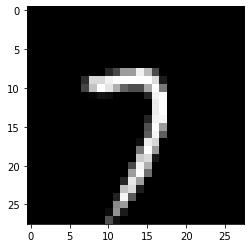

In [42]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인해보자.

0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있다. 

MNIST의 경우, 숫자 0은 `[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]`,   
숫자 6은 `[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]`의 값을 가진다. 

위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해 보자.

### GAN Generator 구성하기
___


이번 구현은 Tensorflow2의 Subclassing 방법을 이용할 것이다. Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 `__init__()` 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 `call()` 메서드에서 사용해 forward propagation을 진행한다.

이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있다.

먼저 GAN의 Generator를 아래와 같이 구현해보자.

In [43]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅ check")

✅ check


`__init__()` 메서드 안에서 사용할 모든 레이어를 정의했다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것으로 확인된다.

`call()` 메서드에서는 노이즈를 입력받아 `__init__()` 에서 정의된 레이어들을 순서대로 통과한다.

Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 `layers.Reshape()` 을 이용해 (28,28,1) 크기로 변환된다.

### cGAN Generator 구성하기
___

이번에는 cGAN의 Generator의 코드르 살펴보자.

In [44]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅ check")

✅ check


GAN의 Generator보다 구현이 복잡한듯하지만, 이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것뿐이다. 이번에는 여러분이 위 코드를 자세히 보고, 어떠한 연산이 이루어지는지 생각해 보자.

cGAN의 입력은 2개(노이즈 및 레이블 정보)라는 점을 기억해 두자. (이전 GAN 코드와 비교하여 잘 생각해 보자!)

### Question 2.

> 위 코드로 생성한 모델에 대해 입력부터 출력까지 어떤 연산이 이루어지나? (`init()` 메서드에서는 노이즈 및 레이블 입력 각각에 적용할 레이어를 생성했다.)

▶ 
1. 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과한다. (dense_z, dense_y)

2. 1번 문항의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과한다. (tf.concat, conbined_dense)

3. 2번 문항의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력된다. (final_dense, reshape)

## 4. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기


### GAN Discriminator 구성하기
___

이전에 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했다. 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보자.

먼저 GAN의 Discriminator를 아래와 같이 구현할 것이다.

In [45]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅ check")

✅ check


1. 여기에서는 `__init__()` 에 `blocks` 라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았다.

2. 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리하다.

3. Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 `call()` 에서는 가장 먼저 `layers.Flatten()` 이 적용된다.

4. 이어서 레이어들이 쌓여있는 `blocks` 에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시키다.

5. 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### cGAN Discriminator 구성하기
___

다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용된다. Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 한다. 

만약 2개의 fully-connected 레이어를 사용할 때 Maxout을 식으로 표현하면 아래와 같다.

$max(w_1^Tx+b_1, w_2^Tx+b_2)$

이렇게 fully-connected 레이어를 2개만 사용한다면 다차원 공간에서 2개의 면이 교차된 모양의 activation function처럼 작동할 것이다.

다차원 공간은 시각화 하기가 어려운데요. 차원을 낮춰 1차원 fully-connected 레이어라고 가정하면 아래처럼 2개의 직선으로 이루어진 activation function으로 나타낼 수 있다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/e-25-4-1.max-800x600.png)

사용하는 fully-connected 레이어 갯수가 늘어난다면 점점 곡선 형태인 activation function이 될 수 있다.

차원을 늘리면 다차원 공간에 곡면을 나타낼 수 있을 것이지만, 시각화 하기는 쫌 어렵다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-25-4-2.png)

Maxout에 대해 더 깊이 알아보는 것은 추천하지 않습니다만, 원한다면 아래 논문을 참고하자.

- [[Paper]Maxout Networks](https://arxiv.org/pdf/1302.4389.pdf)

아래 코드와 같이 Maxout을 구성할 수 있다.
`tensorflow.keras.layers.Layer` 를 상속받아 레이어를 정의하였다.

이전에 모델을 정의한 것과 비슷하게 `__init__(), call()` 메서드를 구성한다.

In [46]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅ check")

✅ check


`Maxout` 레이어를 구성할 때 units과 pieces의 설정이 필요하며, `units` 차원 수를 가진 fully-connected 레이어를 `pieces` 개만큼 만들고 그중 최댓값을 출력합니다. 

예를 들어, 사용할 `Maxout` 레이어가 `units=100`, `pieces=10` 으로 설정된다면 입력으로부터 100차원의 representation을 10개 만들고, 10개 중에서 최댓값을 가져와 최종 1개의 100차원 representation이 출력된다.

식으로 나타낸다면 아래와 같습니다. (위 예시에서는 각각의 wx+b가 모두 100차원이다)

$max(w_1^Tx+b_1, w_2^Tx+b_2, ...., w_9^Tx+b_9, w_{10}^Tx+b_{10}$

위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있다.

In [47]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅ check")

✅ check


GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, `layers.Flatten()` 이 적용된다.

그리고 이미지 입력 및 레이블 입력 각각은 `Maxout` 레이어를 한 번씩 통과한 후 서로 결합되어 `Maxout` 레이어를 한 번 더 통과한다.

마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### Question 3. 

> 만약 위와 같은 cGAN의 Disciminator에 (28,28,1) 크기 이미지 및 (10,) 크기 레이블이 입력될 때, 연산의 순서를 다음과 같이 나타낼 수 있다.
1. 이미지가 Maxout 레이어를 통과
2. 레이블이 Maxout 레이어를 통과
3. 1)과 2)결과로 나온 representation을 결합(concate) 후 Maxout 레이어를 통과

위 3개 과정의 각 결과 차원 수는 각각 몇일까?

▶ 240, 50, 240

## 5.  내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해 보자.

우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의한다.

진짜 및 가짜를 구별하기 위해 `Binary Cross Entropy` 를 사용하고, `Adam optimizer` 를 이용해 학습할 것이다.

In [48]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅ check")

✅ check


### GAN으로 MNIST 학습하기
___

이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용할 것이다.

여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했다.

In [49]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅ check")

✅ check


위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 보자.

100번의 반복마다 각 손실(loss)을 출력하도록 했다.

In [50]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:1.9789276123046875, D:0.1597869098186493
[1/10 EPOCHS, 200 ITER] G:2.2864792346954346, D:0.14594489336013794
[1/10 EPOCHS, 300 ITER] G:2.3908095359802246, D:0.11831311136484146
[1/10 EPOCHS, 400 ITER] G:3.0572824478149414, D:0.11280937492847443
[2/10 EPOCHS, 100 ITER] G:2.1022286415100098, D:0.37873899936676025
[2/10 EPOCHS, 200 ITER] G:3.2011892795562744, D:0.10076002031564713
[2/10 EPOCHS, 300 ITER] G:2.2734854221343994, D:0.21806246042251587
[2/10 EPOCHS, 400 ITER] G:2.8496618270874023, D:0.2329563945531845
[3/10 EPOCHS, 100 ITER] G:3.200312614440918, D:0.13836756348609924
[3/10 EPOCHS, 200 ITER] G:3.6464457511901855, D:0.07261267304420471
[3/10 EPOCHS, 300 ITER] G:3.732020378112793, D:0.1735190451145172
[3/10 EPOCHS, 400 ITER] G:4.115195274353027, D:0.13562563061714172
[4/10 EPOCHS, 100 ITER] G:3.248711585998535, D:0.0993717610836029
[4/10 EPOCHS, 200 ITER] G:2.831195116043091, D:0.2180488556623459
[4/10 EPOCHS, 300 ITER] G:3.1215739250183105, D:0.10772587

짧은 시간 학습된 모델을 테스트해 보자.

100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화해보자.

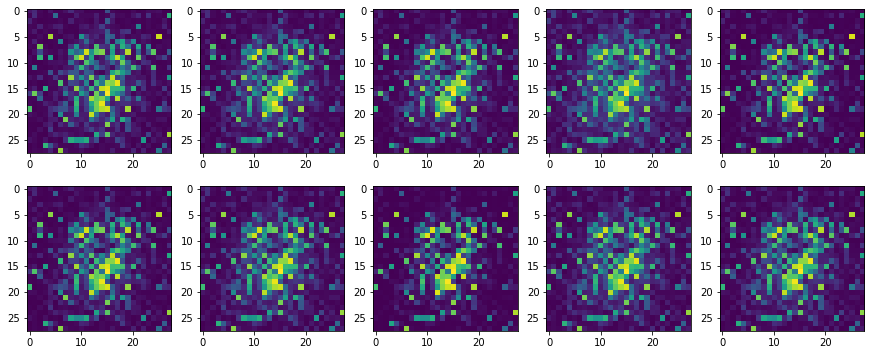

In [51]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나 보다.

위 구현을 그대로 500 epoch 학습한 가중치를 준비해 두었으니 한번 사용해 보자.

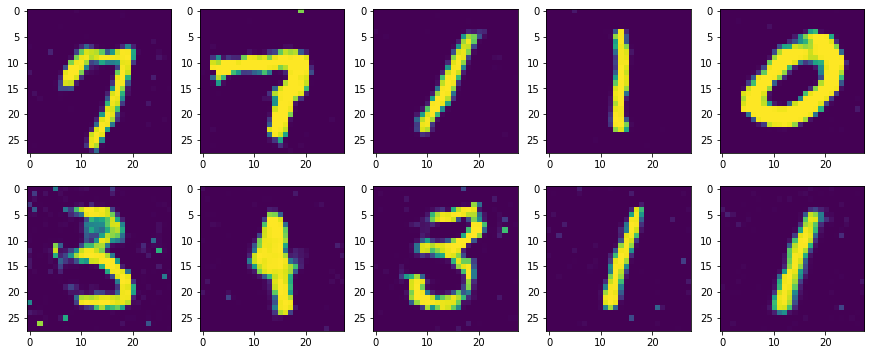

In [52]:
import os
weight_path = '/content/drive/MyDrive/AIFFEL/data/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화하였다.

이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있다.

내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습 시켜 보자.

### cGAN으로 MNIST 학습하기
___

이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용할 것이다.

In [53]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.648171424865723, D:0.011249438859522343
[1/1 EPOCHS, 199 ITER] G:4.358854293823242, D:0.01701013743877411
[1/1 EPOCHS, 299 ITER] G:5.224407196044922, D:0.018763069063425064
[1/1 EPOCHS, 399 ITER] G:4.961492538452148, D:0.026533715426921844


학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없다.

위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 할 것이다.



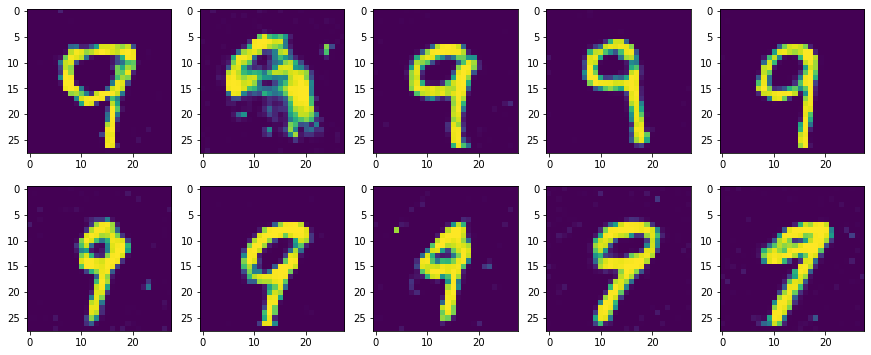

In [54]:
number = 9  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = '/content/drive/MyDrive/AIFFEL/data/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

출력된 10개 시각화 결과로 number에 입력한 숫자에 해당하는 손글씨가 시각화되었다.

cGAN을 사용해 조건을 주고 학습하면 이렇게 특정한 숫자를 만들어내기가 훨씬 쉬울것이다.

# 다음 $STEP$에서는 Pix2Pix로 이미지 변환을 해보자.

# ⛳ 나는 스케치를 너는 채색을..... ⛳

## 목차
___

6. GAN의 입력에 이미지를 넣는다면? Pix2Pix

## 6. GAN의 입력에 이미지를 넣는다면? Pix2Pix

지금까지 cGAN에 대해 알아보고 실험해 보면서, 작은 조건만으로 우리가 원하는 클래스의 이미지를 생성할 수 있음을 확인해보았다.

만약 입력 자체가 조건이 된다면 어떻게 될까???

cGAN과 같이 클래스 레이블 등의 조건을 함께 입력하는 것이 아니라, 조금 더 자세하게 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 줄 수 없을까????

이번에는 **Pix2Pix**는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델을 사용해 볼 것이다.

Pix2Pix를 제안한 논문의 제목은 [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/pdf/1611.07004.pdf) 로 하고자 하는 바가 제목에 그대로 담겨 있다.

Conditional Adversarial Networks로 **Image-to-Image Translation**을 수행한다는 뜻이다.

Conditional Adversarial Networks는 이전까지 알아봤던 cGAN과 같은 구조를 말하는 것인데, Image-to-Image Translation 이란 단어는 무엇을 뜻하는 걸까?

아래 Pix2Pix 논문에서 수행한 결과를 먼저 살펴보자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_results.max-800x600.png)

Image-to-Image Translation은 말 그대로 이미지 간 변환을 말한다.

위 결과의 첫 번째 Labels to Street Scene 이미지는 픽셀 별로 레이블 정보만 존재하는 segmentation map을 입력으로 실제 거리 사진을 생성해 내었고, 이 외에 흑백 사진을 컬러로 변환하거나, 낮에 찍은 사진을 밤에 찍은 사진으로 변환하거나, 가방 스케치를 이용해 채색된 가방을 만들기도 한다.

한 이미지의 픽셀에서 다른 이미지의 픽셀로(pixel to pixel) 변환한다는 뜻에서 Pix2Pix라는 이름으로 불린다. 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구이다.

노이즈와 레이블 정보를 함께 입력했던 cGAN은 fully-connected 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용한다. GAN 구조를 기반으로 하기 때문에 크게 Generator와 Discriminator 두 가지 구성 요소로 이루어진다.

### Pix2Pix (Generator)
___

Generator는 어떠한 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용된다. 여기서 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 이러한 문제에서 흔히 사용되는 구조는 아래 그림과 같은 Encoder-Decoder 구조다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_generator.max-800x600.png)

Encoder에서 입력 이미지$(x)$를 받으면 단계적으로 이미지를 down-sampling 하면서 입력 이미지의 중요한 representation을 학습한다.

Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하여 입력 이미지와 동일한 크기의 변환된 이미지$(y)$를 생성한다. 이러한 과정은 모두 convolution 레이어로 진행되며, 레이어 내의 수많은 파라미터를 학습하여 잘 변환된 이미지를 얻도록 하자.

 여기서 한 가지 짚고 넘어갈 부분은, Encoder의 최종 출력은 위 그림 중간에 위치한 가장 작은 사각형이며, bottleneck 이라고도 불리는 이 부분은 입력 이미지$(x)$의 가장 중요한 특징만을 담고 있다.

과연 이 중요하지만 작은 특징이 변환된 이미지$(y)$를 생성하는데 충분한 정보를 제공할까? 이와 같은 점을 보완하기 위해 논문에서는 Generator 구조를 하나 더 제안으로
아래 그림과 같은 U-Net 구조이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_generator_unet.max-800x600.png)



위에서 살펴본 단순한 Encoder-Decoder로 구성된 Generator와 다른 점은, 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있다는 것이다.

Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 이러한 U-Net 구조의 Generator를 사용해 아래와 같이 단순한 Encoder-Decoder 구조의 Generator를 사용한 결과에 비해 비교적 선명한 결과를 얻을 수 있을 것이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g.max-800x600.png)

여기서 U-Net은 이전에 segmentation 작업을 위해 제안된 구조이다.

U-Net에 대한 자세한 사항은 이번 노드의 학습 범위를 벗어나므로 아래에 잘 정리된 자료를 첨부하니 읽어보면 좋을 것 같다.

- [U-Net 논문 리뷰](https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a)

### Pix2Pix (Loss Function)
___

위 Generator 구조를 보면서 한 번쯤 생각해 보셨을 것 같은 사항으로는 "Generator만으로도 이미지 변환이 가능하지 않을까?"

### Question 4.

> Generator만을 사용한 이미지 변환, 가능할까?

▶ 가능하다. AutoEncoder 형태의 접근은 Generator 만으로 이미지 변환을 진행한다.

변환하고자 하는 이미지를 Encoder에 입력하여 Decoder의 출력으로 변환된 이미지를 얻을 수 있다.

출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산한 후 이를 역전파하여 네트워크를 학습시키면 될 것이다. 

이미지 변환이 가능은 하지만 문제는 변환된 이미지의 품질로, 아래 사진의 L1이라 써있는 결과가 Generator 만을 사용해 변환된 이미지와 실제 이미지 사이의 L1 손실을 이용해 만들어낸 결과이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_loss.max-800x600.png)

L1 이라 쓰여있는 Generator만으로 생성된 결과는 매우 흐릿하다. 이미지를 변환하는데 L1(MAE)이나 L2(MSE) 손실만을 이용해서 학습하는 경우 이렇게 결과가 흐릿해지는 경향이 있다. Generator가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피하다.

반면 위 그림의 cGAN이라 쓰여진 GAN 기반의 학습 방법은 비교적 훨씬 더 세밀한 정보를 잘 표현하고 있다. Discriminator를 잘 속이려면 Generator가 (Ground truth라고 쓰여진 이미지같이) 진짜 같은 이미지를 만들어야 하기 때문이다. 논문에서는 L1손실과 GAN 손실을 같이 사용하면 더욱더 좋은 결과를 얻을 수 있다고 한다. (위 그림의 L1+cGAN)

### Pix2Pix (Discriminator)
___

위 결과에서 보듯 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 위에서 설명한 Generator를 발전시킬 서포터이자 경쟁자, Discriminator가 필요하다.

아래 그림은 DCGAN의 Discriminator를 나타낸다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/dcgan_d.png)

DCGAN의 Discriminator는 생성된 가짜 이미지 혹은 진짜 이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률 값을 출력했다. 

Pix2Pix는 이 과정에서 의문을 갖는다.

> 하나의 전체 이미지에 대해 하나의 확률 값만을 도출하는 것이 진짜 혹은 가짜를 판별하는 데 좋은 것일까?

Pix2Pix는 이러한 의문점을 가지고 아래 그림과 같은 조금 다른 방식의 Discriminator를 사용한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/patchgan.max-800x600.png)

위 그림은 Pix2Pix에서 사용되는 Discriminator를 간략하게 나타낸다.

하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖는다. (위 그림의 Prediction은 16개의 값을 가지고 있다).

위 그림에서 입력 이미지의 파란색 점선은 여러 개의 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역(파란색 점선)에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출한다는 것이다.

이런 방식으로 서로 다른 영역에 대해 진짜/가짜를 나타내는 여러 개의 확률 값을 계산할 수 있으며 이 값을 평균하여 최종 Discriminator의 출력을 생성한다. 

이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 PatchGAN이라고 불린다. 

일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법이다.

아래 그림은 (위 그림의 파란색 점선 같은) 판별 영역을 다양한 크기로 실험하여 결과를 보여준 것이다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/patchgan_results.max-800x600.png)



마지막에 보이는 286x286이라 적힌 이미지는 DCGAN의 Discriminator와 같이 전체 이미지에 대해 하나의 확률 값을 출력하여 진짜/가짜를 판별하도록 학습한 결과다.(입력 이미지 크기가 286x286) 

70x70 이미지는 Discriminator입력 이미지에서 70x70 크기를 갖는 일부 영역에 대해서 하나의 확률 값을 출력한 것이며, 16x16, 1x1로 갈수록 더 작은 영역을 보고 각각의 확률 값을 계산하므로 Discriminator의 출력값의 개수가 더 많다. 

위 4개의 이미지를 살펴보면, 너무 작은 patch를 사용한 결과(1x1, 16x16)는 품질이 좋지 않으며, 70x70 patch를 이용한 결과가 전체 이미지를 사용한 결과(286x286)보다 조금 더 사실적인 이미지를 생성하므로 PatchGAN의 사용이 성공적이라고 볼 수 있을 것 같다.

# 다음 $STEP$에서는 Sketch2Pokemon 데이터를 활용하여 스케치 및 채색을 해보자.

# ⛳ 나는 스케치를 너는 채색을..... ⛳

## 목차
___

7. 난 스케치 너는 채색 (1) 데이터 준비하기

8. 난 스케치 너는 채색 (2) Generator 구성하기

9. 난 스케치 너는 채색 (3) Generator 재구성하기

10. 난 스케치 너는 채색 (4) Discriminator 구성하기

11. 난 스케치 너는 채색 (5) 학습 및 테스트하기

## 7. 난 스케치 너는 채색 (1) 데이터 준비하기

이번에는 앞서 알아본 pix2pix 모델에 대해서 직접 구현하고 실험해 보자.

사용해 볼 데이터셋은 Sketch2Pokemon이라는 데이터셋이다.

- [Sketch2Pokemon info](https://www.kaggle.com/norod78/sketch2pokemon)

위 출처에는 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다.



In [55]:
import os

data_path = "/content/drive/MyDrive/AIFFEL/data/conditional_generation/pokemon_pix2pix_dataset/train/"

print("The number of train examples: ", len(os.listdir(data_path)))

The number of train examples:  830


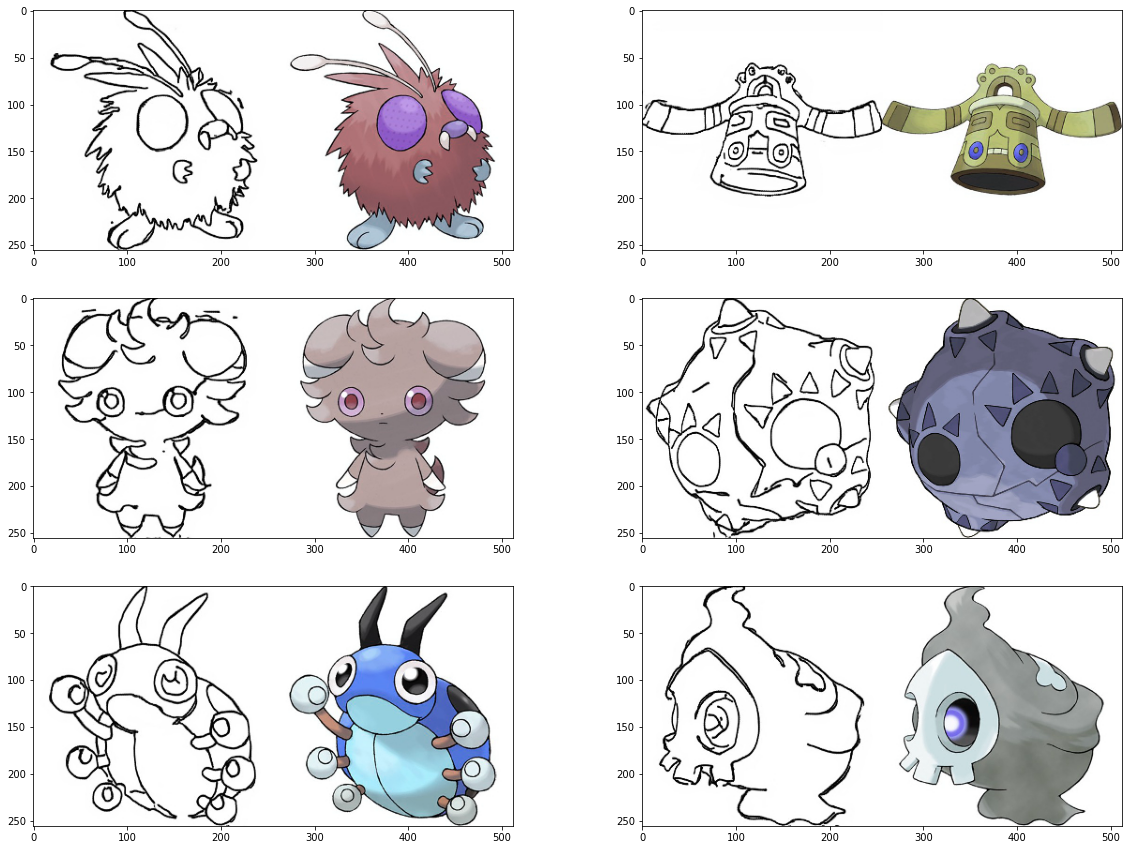

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있다.

이미지를 하나 열어 아래와 같이 크기를 확인해보자.

In [57]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


(256, 512, 3)인 것 같다.

모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같다.

아래의 코드로 이미지를 나누어 보자.

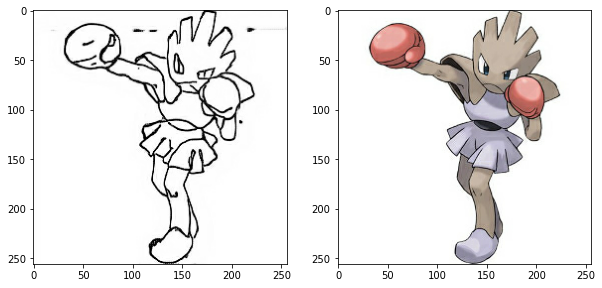

In [58]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

위와 같이 두 개 이미지로 나누었다.

첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표다.

앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐이라,

학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용해 보자.

In [59]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


`apply_augmentation` 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용된다.

### Question 5.

> **위에서 정의한 apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정을 거치는지 순서대로 살펴보자.**

▶

1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.

2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용된다. (tf.pad)

3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop)

4. 3.의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)

5. 4.의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down)

6. 5.의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)

위와 같이 구성한 함수를 데이터에 적용해 시각화해보자.

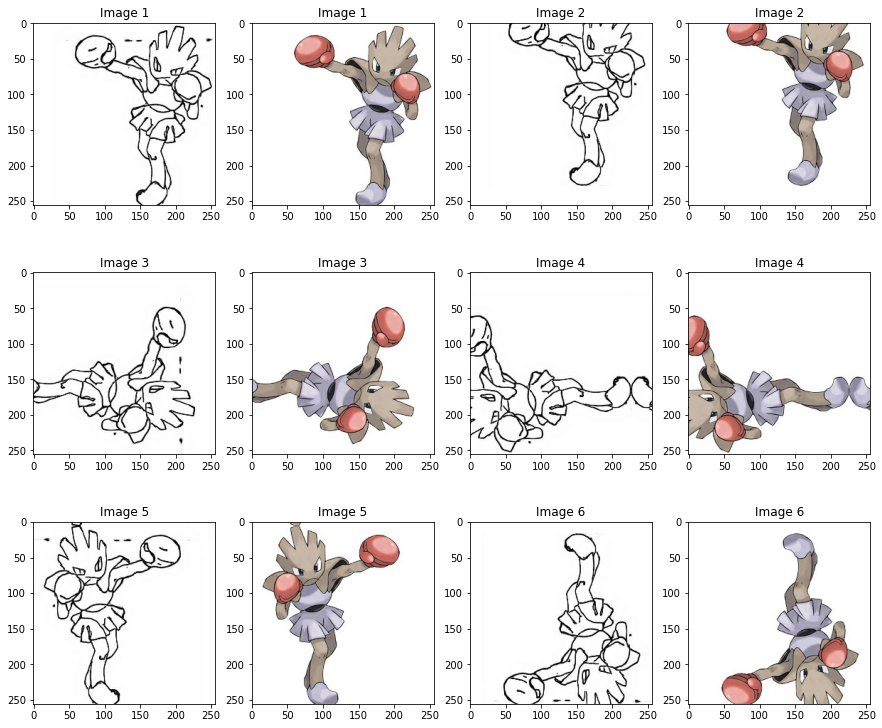

In [60]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

매우 다양한 이미지가 생성되었다.

여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있을 것 같다.

마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해 보자.

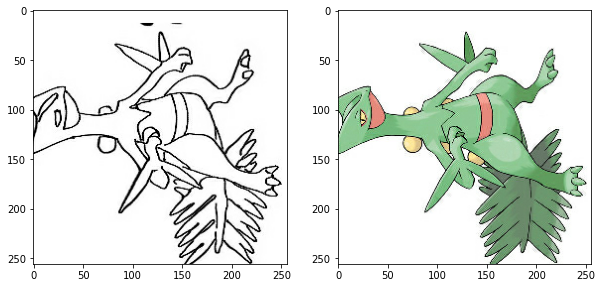

In [61]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 8. 난 스케치 너는 채색 (2) Generator 구성하기구성하기

이제부터 본격적으로 Pix2Pix 구조를 구현해보자. 앞서 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들것이다.



### Generator의 구성요소 알아보기
___

먼저, 아래의 사진은 pix2pix 논문에서 Generator를 구성하는데 필요한 정보인데, 한번 읽어보도록 하자.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/paper_g.png)

### Question 6.

> **논문에서 표기한 encoder의 "C64"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나?**

▶ 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU (위 논문의 아래 단락에 BatchNorm을 사용하지 않는다고 쓰여 있다)

### Question 7.

> **논문에서 표기한 decoder의 "CD512"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타내나?**

▶ 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU

![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_g.max-800x600.png)

위 그림에서 ENCODE 또는 DECODE라고 쓰인 각각의 블록을 기준으로 양쪽에 쓰인 입출력 크기다.

"in"이라고 쓰여진 입력 부분부터 윗줄의 화살표를 쭉 따라가면 계산된 결과의 (width, height) 크기가 점점 절반씩 줄어들며 최종적으로 (1,1)이 되고, 채널의 수는 512까지 늘어나는 것을 확인할 수 있다.
처음 입력부터 시작해서 (1,1,512) 크기를 출력하는 곳까지가 Encoder 부분이다.

이어서 아랫줄 화살표를 따라가면 (width, height) 크기가 점점 두 배로 늘어나 다시 (256, 256) 크기가 되고, 채널의 수는 점점 줄어들어 처음 입력과 같이 3채널이 된다. (1,1,512)를 입력으로 최종 출력까지의 연산들이 Decoder 부분이다.

### Generator 구현하기
___

위 정보들을 토대로 Generator의 Encoder 부분을 구현해보자.

먼저 위 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [62]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅ Check")

✅ Check


`__init__()` 메서드에서 `n_filters`, `use_bn`를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있다.

이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정한다.

Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성할 수 있다.

In [63]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅ Check")

✅ Check


각 블록을 거치면서 사용할 필터의 개수를 `filters` 라는 리스트에 지정해 두었으며, `blocks` 이라는 리스트에는 사용할 블록들을 정의해 넣어두고, `call()` 메서드에서 차례대로 블록들을 통과하게 된다.

Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.

`get_summary` 는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다. 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴봅시다. 만들어 놓은 `get_summary` 메서드를 바로 불러오면 된다.

In [64]:
Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block_24 (EncodeBloc  (None, 128, 128, 64)     3072      
 k)                                                              
                                                                 
 encode_block_25 (EncodeBloc  (None, 64, 64, 128)      131584    
 k)                                                              
                                                                 
 encode_block_26 (EncodeBloc  (None, 32, 32, 256)      525312    
 k)                                                              
                                                                 
 encode_block_27 (EncodeBloc  (None, 16, 16, 512)      2099200   
 k)                                                        

블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인할 수 있다.


이번엔 Decoder를 구현해보자. Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러 번 반복하여 아래와 같이 Decoder를 만들것이다.

In [65]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅ Check")

✅ Check


처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.
마찬가지로 (1,1,512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해 보자.

In [66]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block_21 (DecodeBloc  (None, 2, 2, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_22 (DecodeBloc  (None, 4, 4, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_23 (DecodeBloc  (None, 8, 8, 512)        4196352   
 k)                                                              
                                                                 
 decode_block_24 (DecodeBloc  (None, 16, 16, 512)      4196352   
 k)                                                        

(width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256,256,3) 크기로 알맞게 출력되었다.

위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환되고, Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있을 것이다. 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.

아래 코드와 같이 `tf.keras.Model`을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성해 보자.

In [67]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 encoder_3 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_3 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


model을 살펴봤을 때 Generator를 잘 작동시키기 위해서는 약 4000만 개의 파라미터를 잘 학습시켜야 되겠네요..... ⛹

## 9. 난 스케치 너는 채색 (3) Generator 재구성하기

지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 보았다.
하지만 앞서 설명드린 것처럼 Pix2Pix의 Generator 구조는 아래 그림처럼 두 가지를 제안하였는데,아래 그림을 한번 살펴보자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_g2.max-800x600.png)

위 그림에서 각 구조 아래에 표시된 이미지는 해당 구조를 Generator로 사용했을 때의 결과이다.

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보인다.

이전 단계에서 구현했던 Generator는 위 그림의 Encoder-decoder 구조이다.
Encoder에서 출력된 결과를 Decoder의 입력으로 연결했고, 이 외에 추가적으로 Encoder와 Decoder를 연결시키는 부분은 없었습니다. 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 위 그림의 U-Net 구조를 만들고 실험해 보자.

(아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용하겠다.)

먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현하였었다.

In [68]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅ Check")

✅ Check


여기서 특별히 수정해야 할 부분은 없으니 그대로 가져다가 사용하겠다.

정의된 블록들을 이용해 한 번에 **U-Net Generator**를 정의해 보자. 아래 모델의 `__init__()` 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, `call()`에서 forward propagation 하도록 하자. 이전 구현에는 없었던 skip connection이 `call()` 내부에서 어떻게 구현되었는지 잘 확인해 보자.

In [69]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅ Check")

✅ Check


1. `__init__()` 에서 정의된 `encode_blocks` 및 `decode_blocks` 가 `call()` 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.

2. Encoder와 Decoder 사이의 skip connection을 위해 `features` 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.

3. Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, `features` 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

### Question 8.

> **위 코드의 call() 내에서 features = features[:-1] 는 왜 필요할까?**

▶ Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력(feature리스트 의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니다.

### Question 9.

> **위 코드의 call() 내의 Decoder 연산 부분에서 features[::-1] 는 왜 필요할까?**

▶ Skip connection은 Encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두 번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는.. 등 대칭을 이룬다.(맨 위 U-Net 구조 사진 참고). features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례대로 사용하기 위해서 features의 역순으로 연결한다.

### Question 10.

> **아래와 같은 데이터 A, B가 있을 때,**   
**- 데이터 A 크기 : (32,128,128,200) #(batch, width, height, channel)**  
**- 데이터 B 크기 : (32,128,128,400) #(batch, width, height, channel)**  
**여기서 사용되는 skip connection은 layers.Concatenate() 결과의 크기는 무엇일까?**

▶ (128,128,600) layers.Concatenate() 내에 별다른 설정이 없다면 가장 마지막 축(채널 축)을 기준으로 서로 연결된다.

마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 아래 코드로 확인해 보자.

In [70]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_40 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 encode_block_41 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_40[0][0]']        
                                                                                            

### Question 11.

> **U-Net Generator의 파라미터가 늘어난 곳은 Encoder와 Decoder 중 어디일까?
또한, 두 종류의 Generator 구조에서 동일한 수의 convolution 레이어를 사용했는데, 구체적으로 어느 부분에서 파라미터가 늘어났나?**

▶ U-Net Generator의 Decoder 구조 내 파라미터가 많아졌습니다. 이 부분의 각 convolution 레이어에서 사용된 필터의 수는 두 종류의 Decoder에서 동일하지만, 그 크기가 다르다.

▶ 예를 들어, 이전 Decoder 블록의 출력의 크기가 (16,16,512)라면,
Encoder-decoder Generator의 경우, Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x512 이다.

▶ U-Net Generator의 경우, Encoder 내 블록 출력이 함께 연결되어 Decoder의 다음 블록에서 계산할 convolution의 필터 크기는 4x4x(512+512) 이다.

정리하면, U-Net Generator에서 사용한 skip-connection으로 인해 Decoder의 각 블록에서 입력받는 채널 수가 늘어났고, 이에 따라 블록 내 convolution 레이어에서 사용하는 필터 크기가 커지면서 학습해야 할 파라미터가 늘어난 것이다.

## 10. 난 스케치 너는 채색 (4) Discriminator 구성하기

Generator만으로 좋은 결과를 도출하기에는 부족할 것이다. 조금 더 사실적인 이미지를 생성하기 위한 Pix2Pix를 완성시키기 위해서는 Discriminator가 필요한데, 이번 단계에서 Discriminator를 만들어 Pix2Pix 구조를 완성시켜 보자.

### Discriminator의 구성요소 알아보기
___

아래의 사진은 Pix2Pix 논문에서 Discriminator를 구성하는데 필요한 정보이니, 알아보도록 하자.



![](https://d3s0tskafalll9.cloudfront.net/media/original_images/paper_d.png)

Generator의 구성 요소와 똑같이 "C64" 등으로 표기되어 있다. 진짜 및 가짜 이미지를 판별하기 위해 최종 출력에 sigmoid를 사용하는 것을 제외하면 특별한 변경 사항은 없는 것 같다.

이어서 아래의 보기 쉽게 표현한 그림을 통해 Discriminator의 구조를 머릿속에 조금 더 자세히 그려보도록 하자.

![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)

Discriminator는 2개 입력(위 그림의 "in", "unknown")을 받아 연결(CONCAT)한 후, ENCODE 라고 쓰인 5개의 블록을 통과하게 된다. 이 중 마지막 블록을 제외한 4개 블록은 위 논문에서 표기된 "C64-C128-C256-C512"에 해당하며, 마지막은 1(채널)차원 출력을 위한 블록이 추가되었다.

최종적으로 출력되는 크기는 (30,30,1) 이며, 위 그림의 출력 이전의 2개의 ENCODE 블록을 보면 각각의 출력 크기가 32, 31, 30으로 1씩 감소하는 것을 알 수 있다. Generator에서도 사용했던 2 stride convolution에 패딩을 이용하면 (width, height) 크기가 절반씩 감소할 것이다.

1 stride convolution에 패딩을 하지 않는다면 (width, height) 크기는 (필터 크기가 4이므로) 3씩 감소할 텐데, 그림과 같이 1씩 감소하도록 하려면 무언가 다른 방법을 써야 할 것 같다.



추가적으로 위 그림에서 최종 출력 크기가 (30,30,1)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문이다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정이다.

Convolution Layer에서 kernel크기, stride, padding 등을 토대로 출력 크기를 계산했던 방식을 그대로 사용하면 계산할 수 있는데, 자세한 계산 과정은 아래 링크를 참고하도록 하자.

- [Understanding PatchGAN](https://sahiltinky94.medium.com/understanding-patchgan-9f3c8380c207)

### Discriminator 구현하기
___

마찬가지로 Discriminator에 사용할 기본적인 블록부터 만들어보도록 하자.

In [71]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅ Check")

✅ Check


`__init__()` 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. 필터의 수(`n_filters`), 필터가 순회하는 간격(`stride`), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(`custom_pad`), BatchNorm의 사용 여부(`use_bn`), 활성화 함수 사용 여부(`act`)가 설정 가능하다.

### Question 12.

> **위에서 만든 DiscBlock의 설정을 다음과 같이 하여 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는지, 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 될까?**

1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)

2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)

3. BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)

4. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)

이전 Discriminator를 표현한 그림에서 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 언급했었다. 1씩 감소시키기 위한 방법이 위 질문의 답이며, 이에 대해 자세히 알아보자.

1. (128,128,32) 크기의 입력이 `layers.ZeroPadding2D()`를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다. 출력 : (130,130,32)

2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다. 이는 `OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1` 의 식으로 계산할 수 있다. 채널 수는 사용한 필터 개수와 같다. 출력 : (127,127,64)

3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.


간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 보자.

In [72]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d_5 (ZeroPaddi  (None, 130, 130, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_97 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_57 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainabl

이러한 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다. 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 될것이다.

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞추는 과정을 진행하였ㄷ.

사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어보자.

In [73]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅ Check")

✅ Check


`__init__()` 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.
첫 번째 블록은 단순한 연결(`concat`)을 수행하며, Discriminator의 최종 출력은 `sigmoid` 활성화를 사용하였다.

각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해 보자.

In [74]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_14 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_16 (Concatenate)   (None, 256, 256, 6)  0           ['input_13[0][0]',               
                                                                  'input_14[0][0]']        

두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치한다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/refer_d.max-800x600.png)

임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해보자.

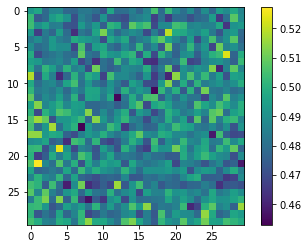

In [75]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

이전 PatchGAN에 대해 설명했던 것처럼, 위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과입니다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있을 것이다. 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용한다.

Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.
다음 단계에서 본격적인 모델 학습을 진행해 보자.



## 11. 난 스케치 너는 채색 (5) 학습 및 테스트하기

이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해 보자. 먼저 학습에 필요한 손실 함수부터 정의하도록 하자.
논문의 여러 실험 결과 중 손실 함수 선택에 따른 결과의 차이는 아래와 같다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/p2p_result_loss2.max-800x600.png)

레이블 정보만 있는 입력에 대해 여러 손실 함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실 함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해 냈었다. 이번 실험에서도 두 가지 손실 함수를 모두 사용해 보도록하자.

In [76]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅ Check")

✅ Check


Generator 및 Discriminator의 손실 계산을 각각 정의하였다.

- **Generator**의 손실 함수 (위 코드의 `get_gene_loss`)는 총 3개의 입력이 있습니다. 이 중 `fake_disc` 는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 `tf.ones_like()`를 사용한다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(`fake_output`)와 실제 이미지(`real_output`) 사이의 MAE(Mean Absolute Error)를 계산한다.

- **Discriminator**의 손실 함수 (위 코드의 `get_disc_loss`)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 `real_disc` 는 "1"로 채워진 벡터와 비교하고, `fake_disc` 는 "0"으로 채워진 벡터와 비교한다.

사용할 optimizer는 논문과 동일하게 설정하였다.

In [77]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅ Check")

✅ Check


하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현하였다.

In [78]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅ Check")

✅ Check


전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.
다만 위 코드의 `gene_total_loss` 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱해야 된다.(## 이 표시가 있는 부분을 확인)

논문에서는 Generator의 손실을 아래와 같이 정의하였다.

$G^* = arg\,\displaystyle\min_{G}\, \displaystyle\min_{D}\, \mathcal{L}_{c\normalsize\,GAN}(G, D) + \lambda\mathcal{L}_{L1}(G)$

위 식에서 λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ=100을 사용하였다.

앞서 정의한 함수를 이용해서 학습을 진행합니다. 우선 10 epoch 학습을 진행해보자.

In [79]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0616                     
L1_loss:0.5217                     
Discriminator_loss:1.1107

EPOCH[1] - STEP[20]                     
Generator_loss:0.8216                     
L1_loss:0.3385                     
Discriminator_loss:1.1946

EPOCH[1] - STEP[30]                     
Generator_loss:1.3530                     
L1_loss:0.2612                     
Discriminator_loss:0.9225

EPOCH[1] - STEP[40]                     
Generator_loss:1.2665                     
L1_loss:0.3001                     
Discriminator_loss:0.9379

EPOCH[1] - STEP[50]                     
Generator_loss:1.0731                     
L1_loss:0.3138                     
Discriminator_loss:0.7170

EPOCH[1] - STEP[60]                     
Generator_loss:1.3024                     
L1_loss:0.3018                     
Discriminator_loss:0.5973

EPOCH[1] - STEP[70]                     
Generator_loss:1.9260                     
L1_loss:0.2357                    

epoch 10의 학습으로 짧게 진행하여 채색이 이쁘겐나오지는 않았다. epoch 수를 늘리면 더 좋은 결과가 나오지 않을까 싶다.

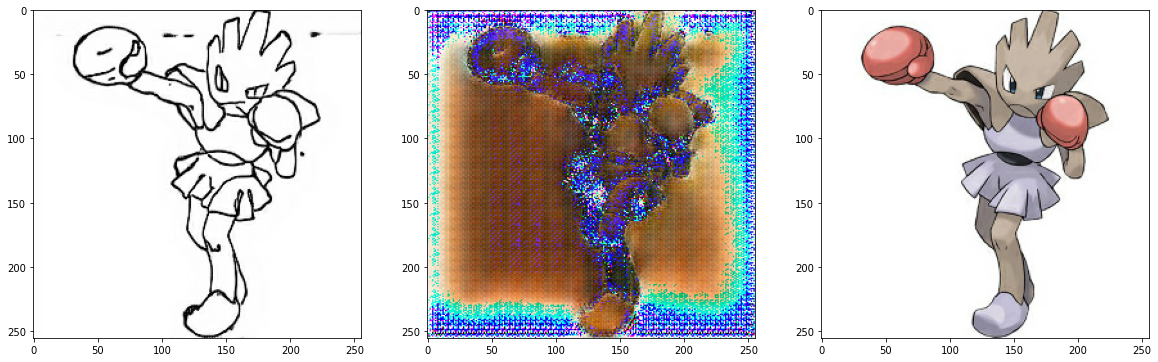

In [80]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과가 아래와 같다고 한다.
이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있다.

Encoder-Decoder Generator, U-Net Generator, Discriminator의 구현까지 많은 것을 배워보았습니다. 앞서 다뤘던 코드의 이해에 큰 어려움이 없었다면, 연습을 통해 이와 비슷한 구조의 모델들 또한 쉽게 구현할 수 있을 것입니다. 

U-Net Generator를 구현했으니 원래 segmentation에 사용되었던 U-Net도 쉽게 구현할 수 있지 않을까 싶네요.

우리의 머리도 몇시간의 학습을 통해 빨리 빨리 기억하면 좋을텐데 말이죠.. 또르르.... 😥